In [1]:
%load_ext autoreload
%autoreload 2

import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

from torch_geometric.datasets import CoraFull, TUDataset, Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric import utils, nn as gnn, transforms as T
from torch_geometric.nn import GCNConv, GATConv
plt.style.use("seaborn-v0_8")

/env_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cora_ds = Planetoid("/mnt/dl/datasets/gnn/cora", name="cora")

In [3]:
cora_ds

cora()

In [4]:
len(cora_ds)

1

In [5]:
cora_ds[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [6]:
data = cora_ds[0]

In [7]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [8]:
data.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [9]:
num_classes = len(data.y.unique())
num_classes, data.y.unique()

(7, tensor([0, 1, 2, 3, 4, 5, 6]))

In [10]:
data.cuda()

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [11]:
class NodeClassification(nn.Module):
    
    def __init__(self, in_dim, hiddens):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hiddens[0])
        self.conv2 = GCNConv(hiddens[0], hiddens[1])
        self.conv3 = GCNConv(hiddens[1], hiddens[2])
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, 0.1, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, 0.1, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        return x        

In [12]:
model = NodeClassification(data.x.size(1), [762, 256, num_classes]).cuda()

In [13]:
adam = torch.optim.Adam(model.parameters(), 1e-3)

In [14]:
losses = []
criterion = nn.CrossEntropyLoss()
for i in range(40):
    yhat = model(data.x, data.edge_index)
    adam.zero_grad()
    loss = criterion(yhat[data.train_mask], data.y[data.train_mask])
    loss.backward()
    adam.step()
    losses.append(loss.item())

    

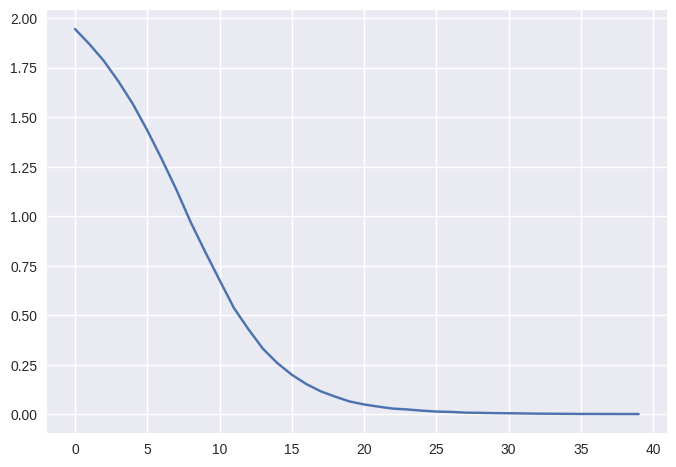

In [15]:
plt.plot(losses)

In [16]:
yhat = model(data.x, data.edge_index)
yhat = yhat[data.val_mask].argmax(-1)
y = data.y[data.val_mask]
acc = (yhat == y).float().sum() * 100. / y.shape[-1]
acc

tensor(75.8000, device='cuda:0')

In [17]:
class NodeClassification2(nn.Module):
    
    def __init__(self, in_dim, hiddens):
        super().__init__()
        self.conv1 = GATConv(in_dim, hiddens[0])
        self.conv2 = GATConv(hiddens[0], hiddens[2])
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x        

In [18]:
model = NodeClassification2(data.x.size(1), [762, 256, num_classes]).cuda()
adam = torch.optim.Adam(model.parameters(), 1e-2)
losses = []
criterion = nn.CrossEntropyLoss()
for i in range(100):
    yhat = model(data.x, data.edge_index)
    adam.zero_grad()
    loss = criterion(yhat[data.train_mask], data.y[data.train_mask])
    loss.backward()
    adam.step()
    losses.append(loss.item())

In [19]:
yhat = model(data.x, data.edge_index)
yhat = yhat[data.val_mask].argmax(-1)
y = data.y[data.val_mask]
acc = (yhat == y).float().sum() * 100. / y.shape[-1]
acc

tensor(63.6000, device='cuda:0')